In [1]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

/Users/ynee/Documents/NUS/venv3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
module 'torch' has no attribute 'compiler'

In [132]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=3)
state_dict=torch.load('bert_rumor_detection.pth')

state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

model.load_state_dict(state_dict,strict=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [133]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="SEQ_CLS", 
    r=16,  # rank
    lora_alpha=32, 
    lora_dropout=0.1, 
)

model = get_peft_model(model, lora_config)


In [134]:
from torch.utils.data import Dataset
import json

class MyRumorDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts=texts
        self.labels=labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = int(self.labels.iloc[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt",
            return_attention_mask=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [135]:
import pandas as pd
import json

with open('matched_data.jsonl', 'r', encoding='utf-8') as f:
    data = []
    for line in f:
        line = line.strip()  # Remove any leading/trailing spaces
        if line:  # Ensure it's not an empty line
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {line}")
                print(f"Error message: {e}")

df = pd.DataFrame(data)

# Split 'policies' into two columns: 'policy_text' and 'entities'
df['entities_in_policy'] = df['policies'].apply(lambda x: x[0]['entities'] if isinstance(x, list) and len(x) > 0 else None)
df['policies'] = df['policies'].apply(lambda x: x[0]['policy_text'] if isinstance(x, list) and len(x) > 0 else None)
columns = [col for col in df.columns if col != 'label']  # All columns except 'label'
columns.append('label')  # Append 'label' as the last column
df = df[columns]

df.head(10)

,id,text,entities,policies,entities_in_policy,label
0,P001,The Texas Heartbeat Act prohibits abortions af...,"[[Texas Heartbeat Act, LAW], [six weeks, TIME]]",A physician may not knowingly perform or induc...,"[[fetal heartbeat, MEDICAL]]",truth
1,P002,SB8 allows anyone to sue anyone who 'aids or a...,"[[SB8, LAW], [$10,000, MONEY]]",If a claimant prevails in an action brought un...,"[[$10,000, MONEY]]",truth
2,P003,"Under the Texas Heartbeat Act, the state's att...","[[Texas Heartbeat Act, LAW], [attorney general...",Notwithstanding Section 171.005 or any other l...,"[[private civil actions, LEGAL]]",truth
3,P004,The law defines pregnancy as beginning at fert...,"[[fertilization, MEDICAL], [implantation, MEDI...",'Pregnancy' means the human female reproductiv...,"[[fertilization, MEDICAL]]",truth
4,P005,Texas will imprison doctors who perform aborti...,"[[doctors, PROFESSION], [imprison, LEGAL]]","Any person, other than an officer or employee ...","[[civil action, LEGAL]]",rumor
5,P006,Physicians are required to document if an abor...,"[[medical emergency, MEDICAL], [document, ACTI...",If an abortion is performed or induced on a pr...,"[[medical emergency, MEDICAL], [written docume...",truth
6,P007,Women who have abortions can be sued and fined...,"[[women, DEMOGRAPHIC], [sued, LEGAL], [fined, ...",This subchapter may not be construed to: (1) a...,"[[woman, DEMOGRAPHIC], [cause of action, LEGAL]]",rumor
7,P008,Texas SB8 allows a rapist to sue a doctor who ...,"[[rapist, CRIMINAL], [victim, PERSON]]","Notwithstanding any other law, a civil action ...","[[rape, CRIMINAL], [sexual assault, CRIMINAL],...",rumor
8,P009,A provision within SB8 states that ignorance o...,"[[ignorance of the law, LEGAL], [defense, LEGAL]]","Notwithstanding any other law, the following a...","[[ignorance, CONCEPT], [mistake of law, LEGAL]]",truth
9,P010,The Texas Heartbeat Act prohibits enforcement ...,"[[state officials, PERSON], [federal courts, O...",Notwithstanding Section 171.005 or any other l...,"[[private civil actions, LEGAL]]",unverified


In [136]:
df['label'] = df['label'].map({'truth': 0, 'rumor': 1, 'unverified':2})

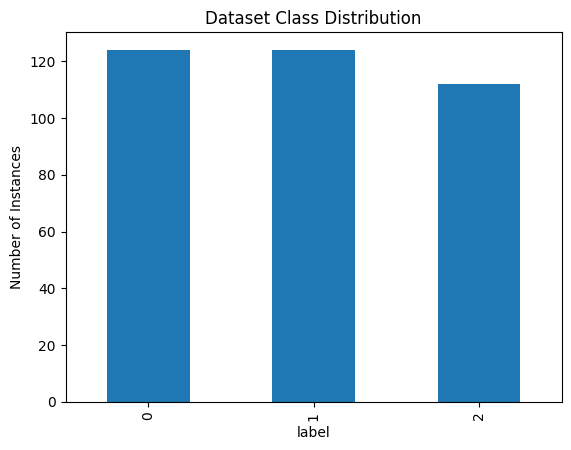

In [137]:
# Plotting a bar chart for visual analysis
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Dataset Class Distribution")
plt.ylabel("Number of Instances")
plt.show()

In [138]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

In [139]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [140]:
# Create datasets
# train_text=train_df['text'].tolist()
# train_label=train_df['label'].tolist()

train_dataset = MyRumorDataset(
    texts=train_df['text'],
    labels=train_df['label'],
    tokenizer=tokenizer,
)

# val_text=val_df['text'].tolist()
# val_label=val_df['label'].tolist()

val_dataset = MyRumorDataset(
    texts=val_df['text'],
    labels=val_df['label'],
    tokenizer=tokenizer,
)


In [141]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')  # or 'macro' if multi-class

    print("Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, preds))
    print("Classification Report:")
    print(classification_report(true_labels, preds, digits=4))

    return acc, precision, recall, f1

In [142]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32)

In [143]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

In [144]:
optimizer = AdamW(model.parameters(), lr=1e-4,weight_decay=0.01)
loss_fn = CrossEntropyLoss()

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=200,
    num_training_steps=len(train_loader) * num_epochs  # Number of steps per epoch * number of epochs
)

In [145]:
from sklearn.metrics import f1_score

In [146]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()

        optimizer.step()
        scheduler.step()  # Update learning rate scheduler

        # Keep track of the running loss
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}")

    # Evaluate on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            # Calculate accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item() / len(all_labels)
    val_f1 = f1_score(all_labels, all_preds, average='macro')  # macro for multi-class balance

    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

Epoch 1/20, Loss: 1.1851
Validation Loss: 1.1744, Accuracy: 0.3472, F1 Score: 0.1736
Epoch 2/20, Loss: 1.1747
Validation Loss: 1.1562, Accuracy: 0.3472, F1 Score: 0.1736
Epoch 3/20, Loss: 1.1598
Validation Loss: 1.1323, Accuracy: 0.3472, F1 Score: 0.1736
Epoch 4/20, Loss: 1.1386
Validation Loss: 1.1119, Accuracy: 0.3472, F1 Score: 0.1959
Epoch 5/20, Loss: 1.1150
Validation Loss: 1.1009, Accuracy: 0.3750, F1 Score: 0.2985
Epoch 6/20, Loss: 1.0954
Validation Loss: 1.0926, Accuracy: 0.4306, F1 Score: 0.3752
Epoch 7/20, Loss: 1.0725
Validation Loss: 1.0753, Accuracy: 0.4167, F1 Score: 0.4133
Epoch 8/20, Loss: 1.0608
Validation Loss: 1.0193, Accuracy: 0.5417, F1 Score: 0.5374
Epoch 9/20, Loss: 1.0017
Validation Loss: 0.9124, Accuracy: 0.5139, F1 Score: 0.5106
Epoch 10/20, Loss: 0.8880
Validation Loss: 0.8229, Accuracy: 0.5694, F1 Score: 0.5917
Epoch 11/20, Loss: 0.8008
Validation Loss: 0.8454, Accuracy: 0.5972, F1 Score: 0.5617
Epoch 12/20, Loss: 0.7579
Validation Loss: 0.7886, Accuracy: 0.

In [149]:
#save the weight/config/tokenizer
output_dir = "./saved_lora_model"
torch.save(model.state_dict(), f"{output_dir}/pytorch_model.bin")
model.config.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./saved_lora_model\\tokenizer_config.json',
 './saved_lora_model\\special_tokens_map.json',
 './saved_lora_model\\vocab.txt',
 './saved_lora_model\\added_tokens.json')